# Imports

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Local imports
!pip install zat
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix

# Printing versions
print('zat: {:s}'.format(zat.__version__))
print('Numpy: {:s}'.format(np.__version__))

     |████████████████████████████████| 225kB 5.2MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 47.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=c289d39c777ec1cca6ce48cc54dd2e87353b8e46f4b1ad6d738708f6ad30194f
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
zat: 0.4.2
Numpy: 1.19.5


## Quickly go from Zeek log to Pandas DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a Pandas dataframe from a Zeek log
zeek_df = pd.read_csv('/content/drive/MyDrive/Universita/Magistrale/Tesi/ZeekML/Logs/flows.csv', index_col=None)

# Print out the head of the dataframe

zeek_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   src_ip             3662 non-null   object 
 1   dst_ip             3662 non-null   object 
 2   src_port           3662 non-null   int64  
 3   dst_port           3662 non-null   int64  
 4   protocol           3662 non-null   int64  
 5   timestamp          3662 non-null   object 
 6   flow_duration      3662 non-null   float64
 7   flow_byts_s        3662 non-null   float64
 8   flow_pkts_s        3662 non-null   float64
 9   fwd_pkts_s         3662 non-null   float64
 10  bwd_pkts_s         3662 non-null   float64
 11  tot_fwd_pkts       3662 non-null   int64  
 12  tot_bwd_pkts       3662 non-null   int64  
 13  totlen_fwd_pkts    3662 non-null   int64  
 14  totlen_bwd_pkts    3662 non-null   int64  
 15  fwd_pkt_len_max    3662 non-null   float64
 16  fwd_pkt_len_min    3662 

#Left Join with Modbus requests

In [ ]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
modbus_df = log_to_df.create_dataframe('/content/drive/MyDrive/Universita/Magistrale/Tesi/ZeekML/Logs/modbus.log')

zeek_df.tail()
modbus_merge_flow= pd.merge(zeek_df, modbus_df,  how='left', left_on=['src_ip','src_port'], right_on = ['id.orig_h','id.orig_p'])

modbus_merge_flow.to_csv("Modbus_flows_label.csv")

#Do the same with s7comm

#Take rows with non null Function codes
#modbus_merge_flow = modbus_merge_flow[modbus_merge_flow['func'].notna()]



#Left Join with s7comm requests

In [ ]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
s7comm_df = log_to_df.create_dataframe('/content/drive/MyDrive/Universita/Magistrale/Tesi/ZeekML/Logs/s7comm.log')

s7comm_df.tail()
merge_flow= pd.merge(modbus_merge_flow, s7comm_df,  how='left', left_on=['src_ip','src_port'], right_on = ['id.orig_h','id.orig_p'])

merge_flow.to_csv("Flows_and_Funcs.csv")

merge_flow

,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_std,pkt_len_var,fwd_header_len,bwd_header_len,fwd_seg_size_min,fwd_act_data_pkts,flow_iat_mean,flow_iat_max,flow_iat_min,flow_iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,...,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,uid_x,id.orig_h_x,id.orig_p_x,id.resp_h_x,id.resp_p_x,func,exception,uid_y,id.orig_h_y,id.orig_p_y,id.resp_h_y,id.resp_p_y,rosctr,parameter,item_count,data_info
0,198.199.98.246,192.168.1.4,53534,102,6,2021-01-04 18:07:11,398093.0,1034.934048,15.071855,10.047903,5.023952,4,2,272,140,74.0,66.0,68.000000,3.464102,74.0,66.0,70.0,4.000000,74,66,68.666667,3.771236,14.222222,80,40,20,0,7.961860e+04,198373.0,186.0,9.695256e+04,398093.0,199151.0,383.0,132697.666667,...,68.666667,14600,510,197570.0,186.0,98878.000000,98692.000000,198187.0,197545.0,1.978660e+05,3.210000e+02,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN
1,198.199.98.246,192.168.1.4,57026,502,6,2021-01-04 18:07:18,393550.0,1046.880955,15.245839,10.163893,5.081946,4,2,272,140,74.0,66.0,68.000000,3.464102,74.0,66.0,70.0,4.000000,74,66,68.666667,3.771236,14.222222,80,40,20,0,7.871000e+04,195832.0,355.0,9.529578e+04,393550.0,196950.0,355.0,131183.333333,...,68.666667,14600,510,193891.0,413.0,97152.000000,96739.000000,195419.0,193068.0,1.942435e+05,1.175500e+03,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN
2,198.199.98.246,192.168.1.4,55236,102,6,2021-01-04 18:13:14,396969.0,1037.864418,15.114530,10.076354,5.038177,4,2,272,140,74.0,66.0,68.000000,3.464102,74.0,66.0,70.0,4.000000,74,66,68.666667,3.771236,14.222222,80,40,20,0,7.939380e+04,197976.0,168.0,9.672452e+04,396969.0,198456.0,608.0,132323.000000,...,68.666667,14600,510,197257.0,168.0,98712.500000,98544.500000,197569.0,197496.0,1.975325e+05,3.650000e+01,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN
3,198.199.98.246,192.168.1.4,58702,502,6,2021-01-04 18:13:18,393809.0,1046.192444,15.235812,10.157208,5.078604,4,2,272,140,74.0,66.0,68.000000,3.464102,74.0,66.0,70.0,4.000000,74,66,68.666667,3.771236,14.222222,80,40,20,0,7.876180e+04,195703.0,376.0,9.543481e+04,393809.0,197450.0,376.0,131269.666667,...,68.666667,14600,510,193837.0,399.0,97118.000000,96719.000000,195185.0,193956.0,1.945705e+05,6.145000e+02,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN
4,198.199.98.246,192.168.1.4,57601,502,6,2021-01-04 18:28:33,392606.0,1049.398124,15.282497,10.188331,5.094166,4,2,272,140,74.0,66.0,68.000000,3.464102,74.0,66.0,70.0,4.000000,74,66,68.666667,3.771236,14.222222,80,40,20,0,7.852120e+04,195002.0,443.0,9.506544e+04,392606.0,196712.0,443.0,130868.666667,...,68.666667,14600,510,193189.0,449.0,96819.000000,96370.000000,194553.0,193086.0,1.938195e+05,7.335000e+02,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

#Dataset Behaviour Labeling based on function codes

In [ ]:
def func(a):
    if "MULTIPLE" in a.upper():
        return "malicious"
    elif "INPUT" in a.upper():
        return "malicious"
    elif "EXCEPTION" in a.upper():
        return "malicious"
    else:
        return "benign"

merge_flow["behaviour"] = merge_flow.func.apply(lambda x: func(x))


merge_flow.to_csv("Flow_labeled.csv")

merge_flow["behaviour"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
4581    benign
4582       NaN
4583       NaN
4584       NaN
4585    benign
Name: behaviour, Length: 4586, dtype: object


Plottiamo il numero di ocorrenze per tipo di funzione invocata

https://github.com/amzn/zeek-plugin-s7comm/blob/master/scripts/consts.zeek

Sezione const cotp_types

#Correlation Matrix


     |████████████████████████████████| 61kB 3.1MB/s 


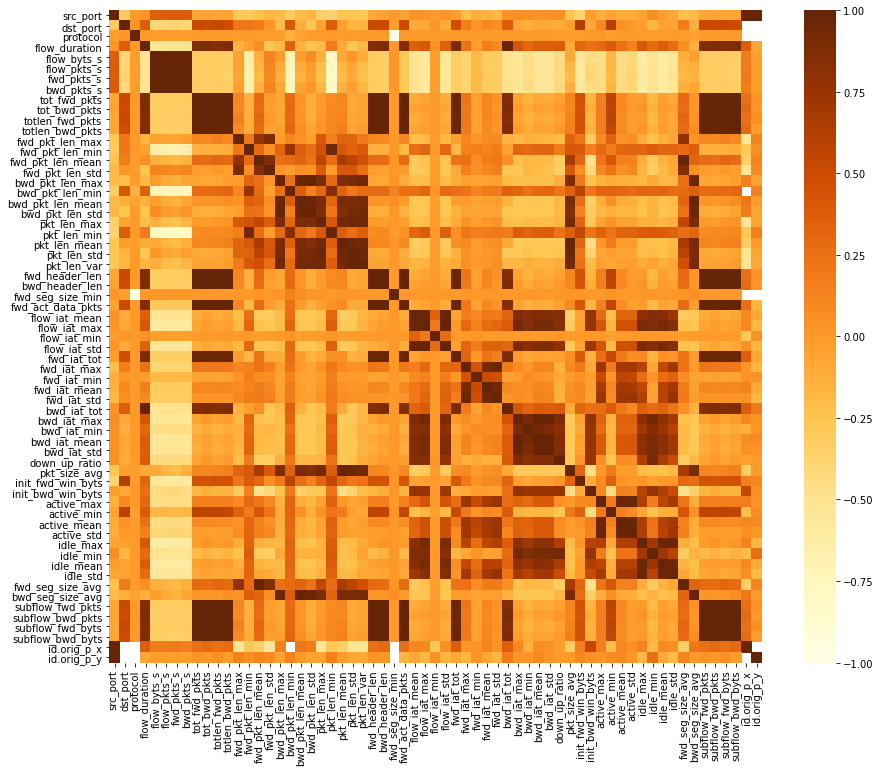

In [25]:
!pip install tikzplotlib
import tikzplotlib

#Exclude objects not calculable
df_corr= merge_flow.drop(['cwe_flag_count','fwd_blk_rate_avg','bwd_blk_rate_avg','bwd_byts_b_avg','fwd_pkts_b_avg','bwd_pkts_b_avg','fwd_byts_b_avg','fwd_byts_b_avg',
                  'fwd_psh_flags','bwd_psh_flags','bwd_urg_flags','fwd_urg_flags','fin_flag_cnt','rst_flag_cnt','syn_flag_cnt','ack_flag_cnt','ece_flag_cnt',
                  'psh_flag_cnt','urg_flag_cnt','id.resp_h_x','id.resp_p_x','id.resp_h_y','id.resp_p_y','item_count'], axis=1)

correlation = df_corr.corr()
plt.subplots(figsize=(15,12))


sns.heatmap(correlation, vmax=1.0, cmap="YlOrBr", square=True,)
plt.savefig('netflow.pdf')

tikzplotlib.save("test.tex")



First, we will remove all the pre-calculated mean, variance, std, min and max values for a smaller feature space.

In [ ]:
cols = [col for col in list(df.columns) if 'mean' not in col and 'variance' not in col 
            and 'std' not in col and 'min' not in col and 'max' not in col and 'ip' not in col and 'timestamp' not in col]
df = df[cols]






In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
data_scaled

array([[ 6.81777734e-04, -4.76667385e-01, -1.65272325e-02, ...,
        -3.91393856e-01, -8.33273044e-02, -3.85712023e-01],
       [ 3.60424788e-01,  2.09789893e+00, -1.65272325e-02, ...,
        -3.91393856e-01, -8.33273044e-02, -3.85712023e-01],
       [ 1.76020438e-01, -4.76667385e-01, -1.65272325e-02, ...,
        -3.91393856e-01, -8.33273044e-02, -3.85712023e-01],
       ...,
       [ 5.93866272e-01, -4.76667385e-01, -1.65272325e-02, ...,
        -5.99086117e-01, -3.46550705e-01, -6.01819340e-01],
       [-1.19887367e+00,  2.09789893e+00, -1.65272325e-02, ...,
         4.39375192e-01, -6.89885576e-01,  1.62462636e-01],
       [-1.53265584e+00,  2.09789893e+00, -1.65272325e-02, ...,
         2.39906681e-02,  3.25813417e-01,  8.86698937e-02]])

Preprocessing IPs


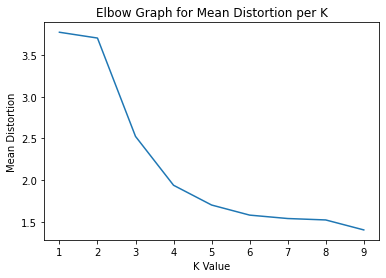

In [ ]:




# using elbow graph to find out the number of k's
def find_k (X, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = X.shape[0]
    sampleSize = X.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(X)[0])
        np.random.shuffle(index)
        X =  X[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(X)
        mean_distortions.append(sum(np.min(pairwise_distances(X, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / X.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel("K Value")
    plt.ylabel("Mean Distortion")
    plt.title("Elbow Graph for Mean Distortion per K")
    plt.show()


find_k(np.matrix(data_scaled), range(1,10),1)

Etichettamento con k-means

In [ ]:

from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4, random_state=0)
kmeans_model.fit(data_scaled)



df['labels'] = kmeans_model.labels_



#Kmeans plot

In [ ]:
sns.scatterplot(x="x", y="y", hue="predicted_label", 
                data=df_data, palette='Paired', s=20);
plt.legend(loc='lower right');


T-sne

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3662 samples in 0.022s...
[t-SNE] Computed neighbors for 3662 samples in 0.309s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3662
[t-SNE] Computed conditional probabilities for sample 2000 / 3662
[t-SNE] Computed conditional probabilities for sample 3000 / 3662
[t-SNE] Computed conditional probabilities for sample 3662 / 3662
[t-SNE] Mean sigma: 109.486292
[t-SNE] Computed conditional probabilities in 0.391s
[t-SNE] Iteration 50: error = 87.0293732, gradient norm = 0.0000083 (50 iterations in 4.769s)
[t-SNE] Iteration 100: error = 83.4846497, gradient norm = 0.0131260 (50 iterations in 3.351s)
[t-SNE] Iteration 150: error = 62.0575638, gradient norm = 0.0027411 (50 iterations in 2.871s)
[t-SNE] Iteration 200: error = 58.4063187, gradient norm = 0.0013506 (50 iterations in 2.786s)
[t-SNE] Iteration 250: error = 56.9993248, gradient norm = 0.0009039 (50 iterations in 2.759s)
[t-SNE] KL divergence after 250 itera

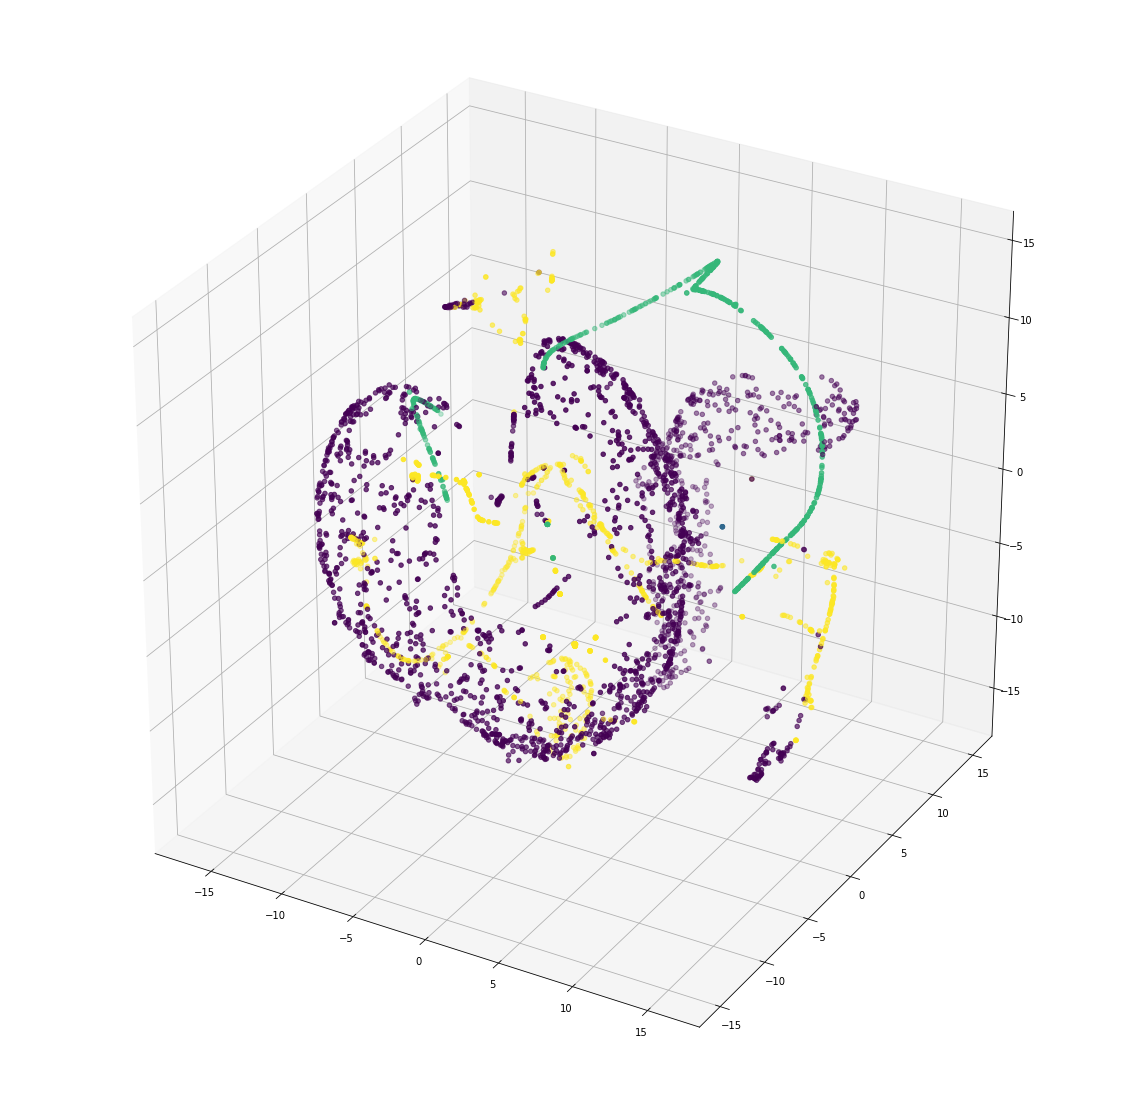

In [ ]:

df.shape
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

model = TSNE(n_components=3, learning_rate=10, random_state=10,verbose=2,n_jobs=2)
X_tsne = model.fit_transform(df) 
plt.figure(figsize=(20,20))
ax = plt.subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:,2], c=kmeans_model.labels_)



#Data Label 1

In [ ]:
df[df['labels'] == 1].head()

,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,pkt_len_var,fwd_header_len,bwd_header_len,fwd_act_data_pkts,fwd_iat_tot,bwd_iat_tot,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,ece_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,labels
241,46939,502,6,71127931.0,260.966399,3.458557,1.658983,1.799574,118,128,8954,9608,19.947188,2360,2560,93,71127931.0,70540843.0,0,0,0,0,1,0,0,0,0,0,0,1.084746,75.455285,64240,509,0.0,0.0,0.0,0.0,0.0,0.0,75.881356,75.062500,0,118,128,8954,9608,1
242,59069,502,6,115941848.0,242.552629,3.148130,1.466252,1.681878,170,195,13439,14683,24.866324,3400,3900,144,115941848.0,115381071.0,0,0,0,0,1,0,0,0,0,0,0,1.147059,77.046575,64240,509,0.0,0.0,0.0,0.0,0.0,0.0,79.052941,75.297436,0,170,195,13439,14683,1
243,40941,502,6,72122286.0,236.196063,3.119701,1.594514,1.525187,115,110,8696,8339,17.876543,2300,2200,87,72122286.0,71558354.0,0,0,0,0,1,0,0,0,0,0,0,0.956522,75.711111,64240,509,0.0,0.0,0.0,0.0,0.0,0.0,75.617391,75.809091,0,115,110,8696,8339,1


In [ ]:
df[df['labels'] == 2]

,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,pkt_len_var,fwd_header_len,bwd_header_len,fwd_act_data_pkts,fwd_iat_tot,bwd_iat_tot,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,ece_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,labels
172,61953,102,6,32200792.0,19.129964,0.310551,0.186331,0.124221,6,4,396,220,51.840000,120,80,6,32200792.0,22147397.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,61.600000,1024,64186,0.0,0.0,0.0,0.0,0.0,0.0,66.0,55.0,0,6,4,396,220,2
173,56583,502,6,32103943.0,12.708719,0.218042,0.031149,0.186893,1,6,60,348,0.489796,20,120,1,0.0,32103570.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
175,56079,102,6,32190417.0,12.674580,0.217456,0.031065,0.186391,1,6,60,348,0.489796,20,120,1,0.0,32190265.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
177,40256,102,6,32187613.0,12.675684,0.217475,0.031068,0.186407,1,6,60,348,0.489796,20,120,1,0.0,32187459.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
179,50448,102,6,32071686.0,12.721501,0.218261,0.031180,0.187081,1,6,60,348,0.489796,20,120,1,0.0,32071532.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,29200,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,35646,502,6,32274103.0,12.641715,0.216892,0.030985,0.185908,1,6,60,348,0.489796,20,120,1,0.0,32273692.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
3596,34555,102,6,31925004.0,12.779951,0.219264,0.031323,0.187940,1,6,60,348,0.489796,20,120,1,0.0,31924827.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
3598,52401,102,6,31982730.0,12.756885,0.218868,0.031267,0.187601,1,6,60,348,0.489796,20,120,1,0.0,31982550.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2
3607,42843,102,6,32469510.0,12.565635,0.215587,0.030798,0.184789,1,6,60,348,0.489796,20,120,1,0.0,32469339.0,0,0,0,0,1,0,0,0,0,0,0,6.000000,58.285714,65535,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.0,58.0,0,1,6,60,348,2


In [ ]:
df[df['labels'] == 3]

,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,pkt_len_var,fwd_header_len,bwd_header_len,fwd_act_data_pkts,fwd_iat_tot,bwd_iat_tot,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,ece_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,labels
0,53534,102,6,398093.0,1034.934048,15.071855,10.047903,5.023952,4,2,272,140,14.222222,80,40,0,398093.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,68.666667,14600,510,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,3
1,57026,502,6,393550.0,1046.880955,15.245839,10.163893,5.081946,4,2,272,140,14.222222,80,40,0,393550.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,68.666667,14600,510,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,3
2,55236,102,6,396969.0,1037.864418,15.114530,10.076354,5.038177,4,2,272,140,14.222222,80,40,0,396969.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,68.666667,14600,510,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,3
3,58702,502,6,393809.0,1046.192444,15.235812,10.157208,5.078604,4,2,272,140,14.222222,80,40,0,393809.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,68.666667,14600,510,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,3
4,57601,502,6,392606.0,1049.398124,15.282497,10.188331,5.094166,4,2,272,140,14.222222,80,40,0,392606.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,68.666667,14600,510,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,70.0,0,4,2,272,140,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,36896,502,6,3930423.0,184.204092,2.544255,1.526553,1.017702,6,4,412,312,138.240000,120,80,1,3930423.0,3736226.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,72.400000,29200,509,0.0,0.0,0.0,0.0,0.0,0.0,68.666667,78.0,0,6,4,412,312,3
3656,37342,502,6,3513787.0,209.176026,2.845932,1.707559,1.138373,6,4,415,320,199.050000,120,80,1,3513787.0,3319446.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,73.500000,29200,509,0.0,0.0,0.0,0.0,0.0,0.0,69.166667,80.0,0,6,4,415,320,3
3657,37580,502,6,837180.0,864.808046,11.944863,7.166918,4.777945,6,4,412,312,138.240000,120,80,1,837180.0,643088.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,72.400000,29200,509,0.0,0.0,0.0,0.0,0.0,0.0,68.666667,78.0,0,6,4,412,312,3
3658,37696,502,6,193519.0,1074.829862,15.502354,10.334903,5.167451,2,1,134,74,43.555556,40,20,1,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,69.333333,29200,65160,0.0,0.0,0.0,0.0,0.0,0.0,67.000000,74.0,0,2,1,134,74,3


In [ ]:
df[df['labels'] == 0]

,src_port,dst_port,protocol,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,pkt_len_var,fwd_header_len,bwd_header_len,fwd_act_data_pkts,fwd_iat_tot,bwd_iat_tot,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,ece_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,labels
9,38600,102,6,0.0,0.000000,0.000000,0.000000,0.000000,1,0,66,0,0.000000,20,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.000000,66.000000,502,0,0.0,0.0,0.0,0.0,0.0,0.0,66.000000,0.0,0,1,0,66,0,0
10,49254,502,6,66189.0,6632.522020,75.541253,45.324752,30.216501,3,2,299,140,1280.160000,60,40,1,65941.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,87.800000,64240,509,0.0,0.0,0.0,0.0,0.0,0.0,99.666667,70.0,0,3,2,299,140,0
11,49254,502,6,57133.0,3465.597816,52.509058,35.006039,17.503019,2,1,132,66,0.000000,40,20,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,66.000000,502,509,0.0,0.0,0.0,0.0,0.0,0.0,66.000000,66.0,0,2,1,132,66,0
57,31271,102,6,142264.0,1251.194961,21.087556,14.058370,7.029185,2,1,120,58,0.888889,40,20,2,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,59.333333,1024,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,58.0,0,2,1,120,58,0
59,6707,502,6,46566.0,3822.531461,64.424688,42.949792,21.474896,2,1,120,58,0.888889,40,20,2,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,59.333333,22949,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,58.0,0,2,1,120,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3617,48666,502,6,54847.0,5323.901034,91.162689,54.697613,36.465076,3,2,180,112,5.440000,60,40,3,54663.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.666667,58.400000,1024,0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,56.0,0,3,2,180,112,0
3618,47297,102,6,144714.0,1230.012300,20.730544,13.820363,6.910181,2,1,120,58,0.888889,40,20,2,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,59.333333,1024,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,58.0,0,2,1,120,58,0
3622,59292,502,6,50056.0,4754.674764,79.910500,59.932875,19.977625,3,1,180,58,0.750000,60,20,3,50056.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.333333,59.500000,1024,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,58.0,0,3,1,180,58,0
3623,29683,102,6,141207.0,1260.560737,21.245406,14.163604,7.081802,2,1,120,58,0.888889,40,20,2,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.500000,59.333333,1024,64240,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,58.0,0,2,1,120,58,0
